In [1]:
# korekta błędu w Keras po zmianie w bibliotece numpy
import numpy as np
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# wyłączenie ostrzeżeń
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 5.2 Trenowanie konwolucyjnej sieci neuronowej na małym zbiorze danych


Konieczność trenowania modelu klasyfikacji obrazów na bardzo małej ilości danych jest często spotykaną sytuacją podczas prywatnej pracy nad problemami analizy obrazu. „Mała liczba” próbek może oznaczać różną liczbę — od kilkuset do kilkudziesięciu tysięcy obrazów. W tym podrozdziale zajmiemy się praktycznym przykładem klasyfikacji zdjęć przedstawiających psy i koty. Nasz zbiór będzie składał się z 4000 obrazów (2000 z nich będzie przedstawiać koty, a pozostałe 2000 psy). Podczas testowania będziemy korzystać z 2000 zdjęć, 1000 przyda nam się do walidacji, a kolejny 1000 zostanie użyty do testowania.

W tym podrozdziale zajmiemy się jedną strategią rozwiązywania tego problemu — będziemy trenować nowy model od podstaw, korzystając przy tym tylko z dostępnych danych. Zaczniemy od naiwnego trenowania konwolucyjnej sieci neuronowej na 2000 próbek bez stosowania mechanizmu regularyzacji. Utworzymy w ten sposób punkt odniesienia do dalszej pracy — nasz klasyfikator uzyska dokładność na poziomie 71%. Naszym głównym problemem będzie nadmierne dopasowanie modelu do danych treningowych. Wprowadzimy technikę augmentacji danych, która pozwala na zmniejszenie skutków zbytniego dopasowania modelu w przypadku problemów dotyczących przetwarzania obrazu. Technika ta pozwoli zwiększyć dokładność modelu do 82%.

W dalszej części tego rozdziału opiszę dwie kolejne techniki przydatne podczas stosowania uczenia głębokiego na małych zbiorach danych: ekstrakcję cech przy uprzednio trenowanej sieci (rozwiązanie to pozwala na uzyskanie dokładności sięgającej 90–96%) i dostrajanie uprzednio trenowanej sieci (technika ta umożliwia uzyskanie dokładności na poziomie 97%). Te trzy techniki (trenowanie małego modelu od podstaw, ekstrakcja cech przy uprzednio trenowanej sieci i dostrajanie uprzednio trenowanej sieci) pozwolą Ci na późniejszą samodzielną pracę nad problemami klasyfikacji obrazów przy dysponowaniu małą ilością danych.


## Stosowanie uczenia głębokiego w problemach małych zbiorów danych

Niektórzy twierdzą, że uczenie głębokie działa tylko wtedy, gdy możliwe jest uzyskanie dostępu do dużej ilości danych. Stwierdzenie to jest częściowo prawdziwe: główną cechą uczenia głębokiego jest to, że algorytmy tego uczenia mogą samodzielnie wybrać przydatne cechy z treningowego zbioru danych, ale wymagają do tego licznego treningowego zbioru danych. Dotyczy to szczególnie pracy z próbkami o bardzo dużej liczbie wymiarów (przykładem takich próbek są obrazy).

Pojęcie licznego treningowego zbioru danych jest względne. Liczba danych potrzebnych do wytrenowania sieci zależy np. od jej rozmiaru i głębokości. Konwolucyjnej sieci neuronowej nie można wytrenować w celu rozwiązania skomplikowanego problemu na zaledwie kilkudziesięciu przykładach, ale zbiór kilkuset przykładów może okazać się wystarczający, jeżeli model będzie mały i poddany regularyzacji, a zadanie będzie proste. Konwolucyjne sieci neuronowe uczą się lokalnych cech niewrażliwych na przesunięcie, a więc charakteryzują się dużą wydajnością analizy danych w przypadku problemów percepcyjnych. Trenowanie konwolucyjnej sieci neuronowej od podstaw na bardzo małym zbiorze obrazów może dać całkiem sensowne efekty pomimo relatywnego braku danych (bez potrzeby przeprowadzania specjalnej inżynierii cech). Przekonasz się o tym podczas lektury tego podrozdziału.

Ponadto modele uczenia głębokiego mają naturę umożliwiającą stosowanie ich w wielu celach — model klasyfikacji obrazu lub dokonujący konwersji mowy na tekst pisany, który to model został wytrenowany na dużym zbiorze danych, może zostać użyty w celu rozwiązania innego problemu przy niewielkiej ilości zmian. Szczególnie w przypadku przetwarzania obrazu wiele uprzednio wytrenowanych modeli (zwykle modele te trenuje się na zbiorze danych ImageNet) może zostać pobranych z internetu i zastosowanych podczas pracy z małą ilością danych — zabieg ten pozwala na uzyskanie doskonałych wyników. Przykład zastosowania tej techniki przedstawię w dalszej części tego rozdziału. Zacznijmy pracę nad naszym modelem od wczytania danych.

## Pobieranie danych

Będziemy korzystać ze zbioru danych „Dogs vs. Cats”, który nie jest dołączony do pakietu Keras. Został on udostępniony w serwisie Kaggle w ramach konkursu analizy obrazu pod koniec 2013 r. (wówczas sieci konwolucyjne nie były jeszcze popularne). Możesz go pobrać ze strony http://www.kaggle.com/c/dogs-vs-cats/data (musisz posiadać konto w serwisie Kaggle, ale jeżeli go jeszcze nie masz, to założenie go nie będzie stanowić żadnego problemu).

Zdjęcia wchodzące w skład zbioru są kolorowymi obrazami JPEG o średniej rozdzielczości. Oto kilka przykładowych zdjęć ze zbioru, który będziemy za chwilę przetwarzać:


![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Oczywiście konkurs z 2013 r., z którego pochodzi ten zbiór danych, został wygrany przez osoby, które użyły konwolucyjnych sieci neuronowych. Najlepsze rozwiązania uzyskały dokładność na poziomie 95%. W tym przykładzie (w kolejnej sekcji) zbliżysz się do tej wartości pomimo tego, że Twój model będzie trenowany na próbce mniej niż 10% danych udostępnionych uczestnikom konkursu.

Pełny zbiór danych zawiera 25 000 zdjęć psów i kotów (po 12 500 zdjęć należących do każdej z klas) i po skompresowaniu zajmuje 543 MB. Po pobraniu go i rozpakowaniu utworzymy nowy zbiór składający się z trzech podzbiorów: zbioru treningowego zawierającego po 1000 próbek każdej z klas, zbioru walidacyjnego zawierającego po 500 próbek każdej z klas i zbioru testowego zawierającego po 500 próbek każdej z klas.

Oto kod, który wykonuje te operacje:


In [2]:
import os, shutil

In [3]:
# Ścieżka katalogu, do którego rozpakowano oryginalny zbiór danych.
original_dataset_dir = 'DogsCats'

# Katalog, w którym umieszczone zostaną mniejsze zbiory danych.
base_dir = 'Data'
os.mkdir(base_dir)

# Katalogi podzbiorów (zbioru treningowego, walidacyjnego i testowego).
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Katalog z treningowym zbiorem zdjęć kotów.
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Katalog z treningowym zbiorem zdjęć psów.
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Katalog z walidacyjnym zbiorem zdjęć kotów.
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Katalog z walidacyjnym zbiorem zdjęć psów.
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Katalog z testowym zbiorem zdjęć kotów.
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Katalog z testowym zbiorem zdjęć psów.
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

FileExistsError: [WinError 183] Nie można utworzyć pliku, który już istnieje: 'Data'

In [9]:
src

'DogsCats\\cat.0.jpg'

In [10]:
# Kopiuje 1000 pierwszych zdjęć kotów do folderu train_cats_dir.
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [11]:
# Kopiuje 500 kolejnych obrazów kotów do folderu validation_cats_dir.
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Kopiuje 500 kolejnych obrazów kotów do folderu test_cats_dir.
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Kopiuje 1000 pierwszych zdjęć psów do folderu train_dogs_dir.
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Kopiuje 500 kolejnych obrazów kotów do folderu validation_dogs_dir.
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Kopiuje 500 kolejnych obrazów kotów do folderu test_dogs_dir.
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Sprawdźmy, ile zdjęć mamy w poszczególnych podzbiorach:

In [12]:
print('liczba obrazów treningowych kotów:', len(os.listdir(train_cats_dir)))

liczba obrazów treningowych kotów: 1000


In [13]:
print('liczba obrazów treningowych psów:', len(os.listdir(train_dogs_dir)))

liczba obrazów treningowych psów: 1000


In [14]:
print('liczba obrazów walidacyjnych kotów:', len(os.listdir(validation_cats_dir)))

liczba obrazów walidacyjnych kotów: 500


In [15]:
print('liczba obrazów walidacyjnych psów:', len(os.listdir(validation_dogs_dir)))

liczba obrazów walidacyjnych psów: 500


In [16]:
print('liczba obrazów testowych kotów:', len(os.listdir(test_cats_dir)))

liczba obrazów testowych kotów: 500


In [17]:
print('liczba obrazów testowych psów:', len(os.listdir(test_dogs_dir)))

liczba obrazów testowych psów: 500



Uzyskaliśmy zbiór treningowy składający się z 2000 zdjęć, zbiór walidacyjny składający się z 1000 zdjęć i zbiór testowy również zawierający 1000 zdjęć. Każdy zbiór zawiera równą liczbę zdjęć każdej z klas — pracujemy z problemem wyważonej klasyfikacji binarnej, a więc dokładność klasyfikacji jest miarą sukcesu pracy modelu.

## Budowa sieci neuronowej

W poprzednim przykładzie tworzyliśmy konwolucyjną sieć neuronową przetwarzającą zbiór danych MNIST, a więc tworzenie takiej sieci nie jest dla Ciebie niczym nowym. Ponownie zastosujemy strukturę tej sieci: nasza sieć będzie stosem naprzemiennych warstw Conv2D (z funkcja aktywacji relu) i MaxPooling2D.

Tym razem pracujemy z większymi obrazami i bardziej złożonym problemem, a więc musimy dostosować do niego konstrukcję sieci — dodamy do niej jeszcze jedną fazę Conv2D + MaxPooling2D. Rozwiązanie to zmodyfikuje pojemność sieci i zredukuje rozmiar map cech tak, aby nie były one zbyt duże po osiągnięciu warstwy spłaszczania Flatten. Zaczynamy od map wejściowych o rozmiarach 150x150 (to wybrana przeze mnie dowolna wartość), a tuż przed warstwą Flatten kończymy na mapach o rozmiarze 7x7.


Zauważ, że w tej sieci głębokość map cech wzrasta w sposób progresywny (od 32 do 128), a ich wymiary maleją (od 148148 do 77). Sytuacja taka ma miejsce w prawie wszystkich konwolucyjnych sieciach neuronowych.

Próbujemy rozwiązać problem klasyfikacji binarnej, a więc na końcu sieci umieszczamy jedną jednostkę (warstwę Dense o rozmiarze równym 1) i funkcję aktywacji sigmoid. Jednostka ta będzie generować wartości prawdopodobieństwa tego, że analizowany obraz należy do jednej z klas.

In [18]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Przyjrzyjmy się zmianom liczby wymiarów przyszłych map w kolejnych warstwach sieci:

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Na etapie kompilacji skorzystamy jak zwykle z optymalizatora RMSprop. Zakończyliśmy sieć pojedynczą jednostką sigmoid, a wiec skorzystamy z funkcji straty w postaci binarnej entropii krzyżowej (informacje na temat doboru funkcji straty do różnych sytuacji znajdziesz w tabeli 4.1).

In [20]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Wstępna obróbka danych

Przypominam, że dane przed przekazaniem do wejść sieci należy odpowiednio sformatować — przedstawić w formie tensorów wartości zmiennoprzecinkowych. Obecnie dane zapisane na dysku mają formę plików JPG, a w celu przystosowania ich do przetwarzania przez sieć należy:

* Wczytać pliki obrazów.
* Zdekodować format JPEG do siatki pikseli w formacie RGB.
* Zapisać dane w formie tensorów liczb zmiennoprzecinkowych.
* Przeskalować wartości pikseli z zakresu 0–255 do zakresu [0, 1], ponieważ sieci neuronowe lepiej pracują z małymi wartościami wejściowymi.

Może się wydawać to dość pracochłonne, ale pakiet Keras jest wyposażony w narzędzia umożliwiające automatyczne wykonanie procesu konwersji. Pakiet Keras ma moduł keras.preprocessing.image zawierający narzędzia przeznaczone do przetwarzania obrazów. W module tym znajduje się klasa ImageDataGenerator, pozwalająca szybko skonfigurować generatory Pythona, które automatycznie zamienią obrazy zapisane na dysku w tensory przygotowane do skierowania do sieci neuronowej. Skorzystamy z tego gotowego rozwiązania:

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# Przeskalowuje wszystkie obrazy o współczynnik 1/255.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Katalog docelowy.
        train_dir,
        # Zmienia rozdzielczość wszystkich obrazów na 150x150.
        target_size=(150, 150),
        batch_size=20,
        # Używamy funkcji binary_crossentropy w charakterze funkcji straty, a więc potrzebujemy binarnych etykiet.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Przyjrzyjmy się wartościom wygenerowanym przez jeden z generatorów: zwraca on wsad obrazów RGB o wymiarach 150150 (o kształcie (20, 150, 150, 3)) i binarne etykiety (kształt (20, )). W każdym wsadzie znajduje się 20 próbek. Zauważ, że generator zwraca wsady w nieskończoność (wykonuje nieskończoną pętlę, przetwarzając obrazy umieszczone w folderze docelowym). W związku z tym w pewnym momencie pętla musi zostać przerwana poleceniem break:

In [22]:
for data_batch, labels_batch in train_generator:
    print('kształt danych wsadowych:', data_batch.shape)
    print('kształt etykiet danych wsadowych:', labels_batch.shape)
    break

kształt danych wsadowych: (20, 150, 150, 3)
kształt etykiet danych wsadowych: (20,)


Dopasujmy model do danych przy użyciu generatora. W tym celu należy skorzystać z metody fit_generator — jest to odpowiednik metody fit stosowany w przypadku generatorów danych. Metoda ta oczekuje zdefiniowania w pierwszym argumencie generatora, który w nieskończoność będzie zwracał wsady danych wejściowych i ich etykiet. Dane są generowane w nieskończoność, a więc model Keras musi wiedzieć, ile próbek ma pobrać z generatora przed zakończeniem epoki. Służy do tego argument steps_per_epoch: po pobraniu liczby wsadów określanej przez wartość tego argumentu (tj. po wykonaniu odpowiedniej liczby kroków spadku gradientu) proces dopasowywania modelu przejdzie do kolejnej epoki. W naszym przypadku wsady składają się z 20 próbek, a więc musimy wygenerować 100 wsadów w celu wytrenowania modelu na 2000 próbek.

Korzystając z metody fit_generator, możemy — podobnie jak w przypadku metody fit — przekazać argument validation_data. Argument ten może być generatorem danych, a także krotką tablic Numpy. W przypadku przekazania generatora w argumencie validation_data oczekuje się, że generator ten będzie zwracał wsady danych walidacyjnych w nieskończoność. W związku z tym należy zdefiniować wartość argumentu validation_steps określającą liczbę wsadów, która ma zostać pobrana z generatora danych walidacyjnych w celu przeprowadzenia walidacji.

In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 55s 547ms/step - loss: 0.6927 - acc: 0.5285 - val_loss: 0.6885 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 66s 655ms/step - loss: 0.6651 - acc: 0.6015 - val_loss: 0.6337 - val_acc: 0.6470
Epoch 3/30
100/100 [==============================] - 64s 642ms/step - loss: 0.6196 - acc: 0.6685 - val_loss: 0.6112 - val_acc: 0.6620
Epoch 4/30
100/100 [==============================] - 57s 574ms/step - loss: 0.5762 - acc: 0.7010 - val_loss: 0.6016 - val_acc: 0.6710
Epoch 5/30
100/100 [==============================] - 61s 607ms/step - loss: 0.5511 - acc: 0.7065 - val_loss: 0.6026 - val_acc: 0.6620
Epoch 6/30
100/100 [==============================] - 70s 695ms/step - loss: 0.5098 - acc: 0.7455 - val_loss: 0.6043 - val_acc: 0.6820
Epoch 7/30
100/100 [==============================] - 80s 799ms/step - loss: 0.4868 - acc: 0.7540 - val_loss: 0.6144 - val_acc: 0.6560
Epoch 8/30
100/100 [==============================] - 8

Dobrą praktyką jest zapisywanie wszystkich wytrenowanych modeli.

In [24]:
model.save('cats_and_dogs_small_1.h5')

Utwórzmy wykresy straty i dokładności pracy modelu podczas przetwarzania danych treningowych i walidacyjnych"

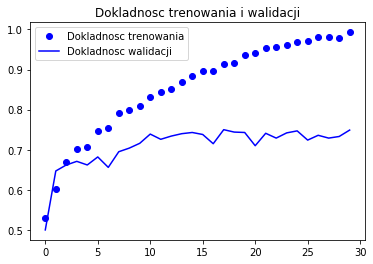

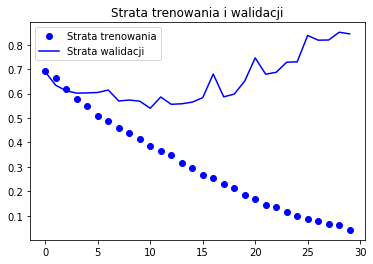

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Na wykresach tych wyraźnie widać nadmierne dopasowanie. Dokładność trenowania wzrasta liniowo wraz z upływem czasu aż do osiągnięcia wartości równej niemalże 100%, a dokładność walidacji nie przekracza poziomu 70 – 72%. Strata walidacji osiąga minimalną wartość po zaledwie pięciu epokach, a następnie stabilizuje się, a strata treningowa maleje liniowo aż do osiągnięcia wartości zbliżonych do 0.

Dysponujemy względnie niewielką liczbą próbek treningowych (2000), a więc nadmierne dopasowanie będzie naszym głównym problemem. Znasz już kilka technik rozwiązywania tego problemu, takich jak porzucanie i rozkład wag (regularyzacja L2). Teraz poznasz nową technikę przeciwdziałania nadmiernemu dopasowaniu, która sprawdza się podczas analizy obrazu i jest używana w praktycznie wszystkich modelach uczenia głębokiego przetwarzających obrazy: augmentację danych.

## Stosowanie techniki augmentacji danych

Nadmierne dopasowanie wynika ze zbyt małej liczby próbek, na których model może się uczyć. Model nie może w takiej sytuacji utworzyć uogólnień, które sprawdzą się podczas przetwarzania nowych danych. Gdybyśmy dysponowali nieskończenie wielkim zbiorem danych treningowych, to na model działałby każdy możliwy aspekt rozkładu danych — nigdy nie uległby przeuczeniu. Augmentacja danych to technika generowania większej liczby elementów treningowego zbioru danych poprzez augmentację próbek na drodze losowych przekształceń zwracających obrazy, które wyglądają wiarygodnie. Celem tego rozwiązania jest to, aby trenowany model nigdy nie zobaczył dwukrotnie tego samego zdjęcia. Dzięki temu model może zauważyć więcej aspektów przetwarzanych danych i utworzyć lepsze uogólnienia.

W pakiecie Keras z techniki tej można skorzystać, konfigurując losowe przekształcenia obrazów wczytywanych przez instancję ImageDataGenerator. Zacznijmy od przeanalizowania przykładu.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

To tylko kilka z dostępnych opcji (informacje na temat pozostałych znajdziesz w dokumentacji pakietu Keras). Przeanalizujmy zaprezentowany kod:

* Wartość rotation_range określa stopnie (0–180) — zakres kątów, o które zostanie wykonany losowy obrót obrazów.
* Zakresy width_shift i height_shift określają ułamki całkowitej szerokości i wysokości obrazów, zakresy te określają ramy, w obrębie których przeprowadza się losowe pionowe i poziome przekształcenia obrazów.
* Parametr shear_range określa zakres losowego przycinania obrazu.
* Parametr zoom_range określa zakres losowego przybliżania fragmentów obrazów.
* Operacja horizontal_flip polega na losowym odbiciu połowy obrazu w płaszczyźnie poziomej — z przekształcenia tego warto korzystać wtedy, gdy nie ma założeń o horyzontalnej asymetrii obrazu (np. w przypadku prawdziwych zdjęć).
* Tryb fill_mode jest strategią wypełniania nowo utworzonych pikseli, które mogą powstać w wyniku obrotu lub przesunięcia.

Przyjrzyjmy się zmodyfikowanym obrazom:

In [11]:
# Operacja importowania modułu zawierającego narzędzia przetwarzajace obrazy.
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Wybieramy obraz do zmodyfikowania.
img_path = fnames[3]

# Wczytujemy obraz i zmieniamy jego rozdzielczość.
img = image.load_img(img_path, target_size=(150, 150))

# Zamieniamy obraz w tablicę Numpy o kształcie (150, 150, 3).
x = image.img_to_array(img)

# Zmieniamy kształt na (1, 150, 150, 3).
x = x.reshape((1,) + x.shape)

# Polecenie .flow() generuje wsady obrazów zmodyfikowanych w sposób losowy. 
# Pętla jest wykonywana w nieskończoność, a więc należy ją w pewnym momencie przerwać!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

NameError: name 'os' is not defined

Jeżeli użyjemy tak skonfigurowanego mechanizmu modyfikującego obrazy, to nasza sieć nigdy nie będzie przetwarzać dwukrotnie tego samego obrazu, ale przetwarzane przez nią obrazy są wciąż bardzo podobne do siebie, ponieważ generujemy je na bazie małej liczby oryginalnych obrazów — nie możemy wygenerować nowych informacji, lecz tylko przedstawiać w nowej formie informacje, którymi dysponujemy. W związku z tym być może nie uda nam się zupełnie wyeliminować nadmiernego dopasowania. W związku z tym później dodamy do sieci warstwę Dropout (umieścimy ją bezpośrednio przed gęsto połączonym klasyfikatorem).

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

NameError: name 'models' is not defined

Przeprowadźmy proces trenowania sieci przy użyciu technik augmentacji danych i odrzucania.

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Pamiętaj o tym, że nie powinno się modyfikować danych walidacyjnych!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Katalog docelowy.
        train_dir,
        # Zmienia rozdzielczość wszystkich obrazów na 150150.
        target_size=(150, 150),
        batch_size=32,
        # Korzystamy z funkcji straty binarnej entropii krzyżowej, a więc potrzebujemy etykiet w formie binarnej.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

NameError: name 'train_dir' is not defined

Zapiszmy utworzony model — będziemy z niego korzystać ponownie w podrozdziale 5.4.

In [31]:
model.save('cats_and_dogs_small_2.h5')

Wygenerujmy ponownie wykresy parametrów modelu:

In [7]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [8]:
acc = history.history['acc']
val_acc = history.history['http://localhost:8888/notebooks/Documents/delepy/5.2.ipynb#val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

NameError: name 'history' is not defined

Dzięki zastosowaniu technik augmentacji danych i odrzucania nie mamy już problemu nadmiernego dopasowania. Krzywe trenowania i walidacji mają podobny przebieg. Dokładność osiągnęła poziom 82%, a więc w skali względnej uległa poprawie o 15% w stosunku do początkowej wersji modelu.

Poprzez dalsze stosowanie technik regularyzacji i dostrajanie parametrów sieci, takich jak liczba filtrów poszczególnych warstw konwolucji lub liczba warstw sieci, możesz zbliżyć się do dokładności na poziomie 86 – 87%. Uzyskanie wyższej dokładności w wyniku trenowania własnej sieci konwolucyjnej od podstaw byłoby trudne, ponieważ dysponujemy małą ilością danych. W celu dalszego zwiększania dokładności musimy skorzystać z wytrenowanego wcześniej modelu. Technika ta będzie tematem przewodnim dwóch kolejnych podrozdziałów.